In [24]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import umap
from torch.nn.functional import mse_loss
from tqdm import tqdm

from autoencoder import Autoencoder
from solver import *

In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=6)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [3]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [4]:
modelpath = f'/home/david/sparsify_models/good_models/01'

sae = load_model(modelpath, 'SAE', epoch=49)
dae = load_model(modelpath, 'DAE', epoch=49)

/tmp/ipykernel_9273/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


In [5]:
test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_images = test_images.squeeze(1)

In [38]:
def add_noise_and_calculate_loss(model, image, start_idx, end_idx):
    with torch.no_grad():
        encoded = model.encode(image)
        mean, std = encoded.mean(), encoded.std()
        encoded[start_idx:end_idx] = torch.randn(end_idx - start_idx) * std + mean
        decoded = model.decode(encoded)
        loss = mse_loss(decoded, image).item()
    return loss, encoded, decoded

def evaluate_single_model(model, test_images):
    first_16_loss = 0.0
    last_16_loss = 0.0
    
    for image in test_images:
        image = torch.tensor(image).view(-1)
        first_16_loss += add_noise_and_calculate_loss(model, image, 0, 16)[0]
        last_16_loss += add_noise_and_calculate_loss(model, image, 16, 32)[0]
    
    first_16_loss /= len(test_images)
    last_16_loss /= len(test_images)
    
    return first_16_loss, last_16_loss

def evaluate_models_with_averaging(test_images, num_models=5):
    sae_results = []
    dae_results = []

    for iteration in tqdm(range(1, num_models + 1), desc="Processing models"):
        modelpath = f'/home/david/sparsify_models/good_models/0{iteration}'
        
        sae = load_model(modelpath, 'SAE', 49)
        dae = load_model(modelpath, 'DAE', 49)
        
        sae_result = evaluate_single_model(sae, test_images)
        dae_result = evaluate_single_model(dae, test_images)
        
        sae_results.append(sae_result)
        dae_results.append(dae_result)
    
    return sae_results, dae_results

In [40]:
sae_results, dae_results = evaluate_models_with_averaging(test_images)

Processing models:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_9273/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_pat

In [ ]:
def plot_results(sae_results, dae_results):
    sae_first_16 = np.mean([r[0] for r in sae_results]), np.std([r[0] for r in sae_results])
    sae_last_16 = np.mean([r[1] for r in sae_results]), np.std([r[1] for r in sae_results])
    dae_first_16 = np.mean([r[0] for r in dae_results]), np.std([r[0] for r in dae_results])
    dae_last_16 = np.mean([r[1] for r in dae_results]), np.std([r[1] for r in dae_results])

    values = [sae_first_16[0], sae_last_16[0], dae_first_16[0], dae_last_16[0]]
    errors = [sae_first_16[1], sae_last_16[1], dae_first_16[1], dae_last_16[1]]
    labels = ['SAE First 16', 'SAE Last 16', 'DAE First 16', 'DAE Last 16']
    colors = ['blue', 'blue', 'red', 'red']

    plt.figure(figsize=(6, 6))

    x = np.arange(len(values))
    plt.bar(x[:2], values[:2], yerr=errors[:2], capsize=5, color='blue', label='DAE')
    plt.bar(x[2:], values[2:], yerr=errors[2:], capsize=5, color='red', label='SAE')

    plt.ylabel('Values')
    plt.title('Bar Chart with Standard Deviation')
    plt.xticks(x, labels)
    plt.legend()
    
    return plt.gcf()

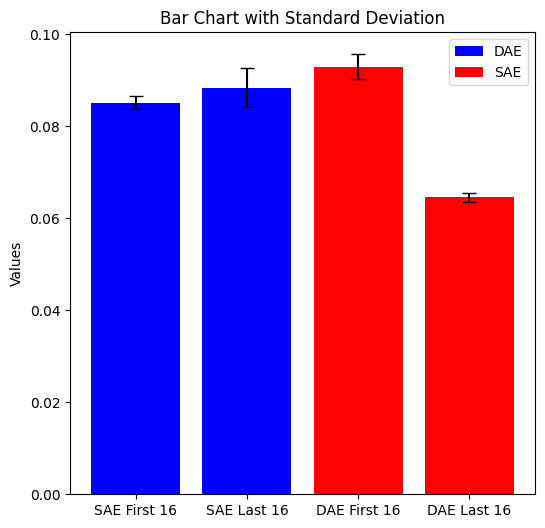

In [ ]:
plot_results(sae_results, dae_results)
plt.show()

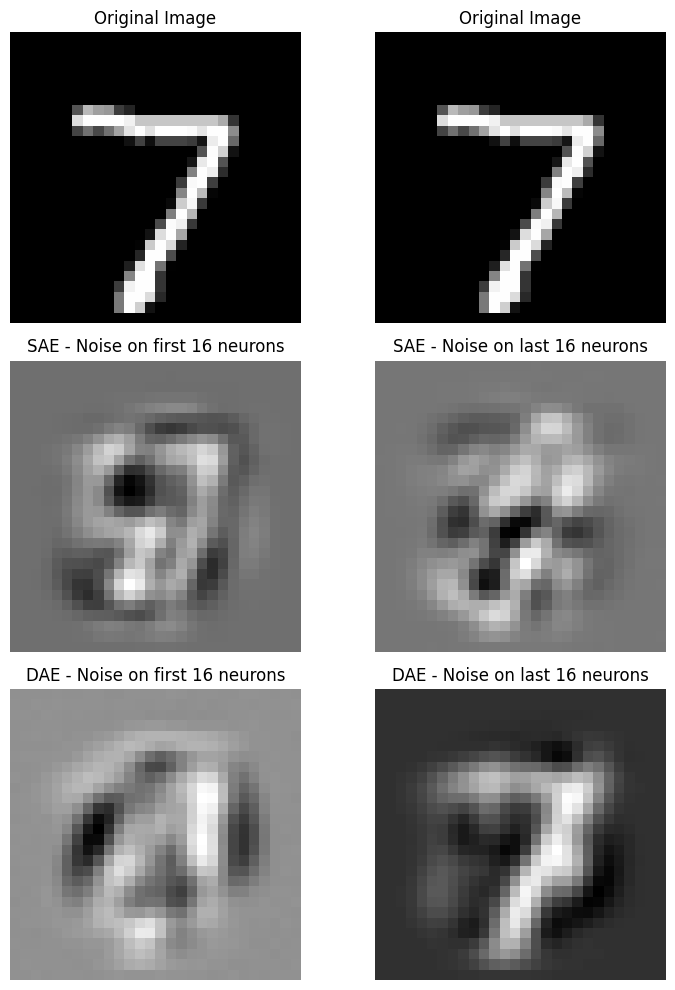

In [59]:
sample_image = torch.tensor(test_images[0]).view(-1)

fig, axes = plt.subplots(3, 2, figsize=(8, 10))

axes[0, 0].imshow(sample_image.view(28, 28), cmap='gray')
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(sample_image.view(28, 28), cmap='gray')
axes[0, 1].set_title("Original Image")
axes[0, 1].axis('off')

_, _, decoded = add_noise_and_calculate_loss(sae, sample_image, 0, 16)
axes[1, 0].imshow(decoded.view(28, 28), cmap='gray')
axes[1, 0].set_title("SAE - Noise on first 16 neurons")
axes[1, 0].axis('off')

_, _, decoded = add_noise_and_calculate_loss(sae, sample_image, 16, 32)
axes[1, 1].imshow(decoded.view(28, 28), cmap='gray')
axes[1, 1].set_title("SAE - Noise on last 16 neurons")
axes[1, 1].axis('off')

_, _, decoded = add_noise_and_calculate_loss(dae, sample_image, 0, 16)
axes[2, 0].imshow(decoded.view(28, 28), cmap='gray')
axes[2, 0].set_title("DAE - Noise on first 16 neurons")
axes[2, 0].axis('off')

_, _, decoded = add_noise_and_calculate_loss(dae, sample_image, 16, 32)
axes[2, 1].imshow(decoded.view(28, 28), cmap='gray')
axes[2, 1].set_title("DAE - Noise on last 16 neurons")
axes[2, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [60]:
sae_test_encodings = []
dae_test_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).view(-1)
        input = image.view(1, -1)
        encoded, decoded = sae(input)
        sae_test_encodings.append(encoded)
        encoded, decoded = dae(input)
        dae_test_encodings.append(encoded)

sae_test_encodings = np.concatenate(sae_test_encodings)
dae_test_encodings = np.concatenate(dae_test_encodings)

sae_encodings_noise_on_early = []
sae_encodings_noise_on_late = []
dae_encodings_noise_on_early = []
dae_encodings_noise_on_late = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).view(-1)
        _, encoded, _ = add_noise_and_calculate_loss(sae, image, 0, 16)
        sae_encodings_noise_on_early.append(sae.encode(decoded))
        _, encoded, _ = add_noise_and_calculate_loss(sae, image, 16, 32)
        sae_encodings_noise_on_late.append(sae.encode(decoded))
        _, encoded, _ = add_noise_and_calculate_loss(dae, image, 0, 16)
        dae_encodings_noise_on_early.append(dae.encode(decoded))
        _, encoded, _ = add_noise_and_calculate_loss(dae, image, 16, 32)
        dae_encodings_noise_on_late.append(dae.encode(decoded))

sae_encodings_noise_on_early = np.concatenate(sae_encodings_noise_on_early)
sae_encodings_noise_on_late = np.concatenate(sae_encodings_noise_on_late)
dae_encodings_noise_on_early = np.concatenate(dae_encodings_noise_on_early)
dae_encodings_noise_on_late = np.concatenate(dae_encodings_noise_on_late)

In [61]:
reducer = umap.UMAP(n_components=2)
sae_umap = reducer.fit_transform(sae_test_encodings)

reducer = umap.UMAP(n_components=2)
dae_umap = reducer.fit_transform(dae_test_encodings)

reducer = umap.UMAP(n_components=2)
sae_umap_noise_on_early = reducer.fit_transform(sae_encodings_noise_on_early)

reducer = umap.UMAP(n_components=2)
sae_umap_noise_on_late = reducer.fit_transform(sae_encodings_noise_on_late)

reducer = umap.UMAP(n_components=2)
dae_umap_noise_on_early = reducer.fit_transform(dae_encodings_noise_on_early)

reducer = umap.UMAP(n_components=2)
dae_umap_noise_on_late = reducer.fit_transform(dae_encodings_noise_on_late)

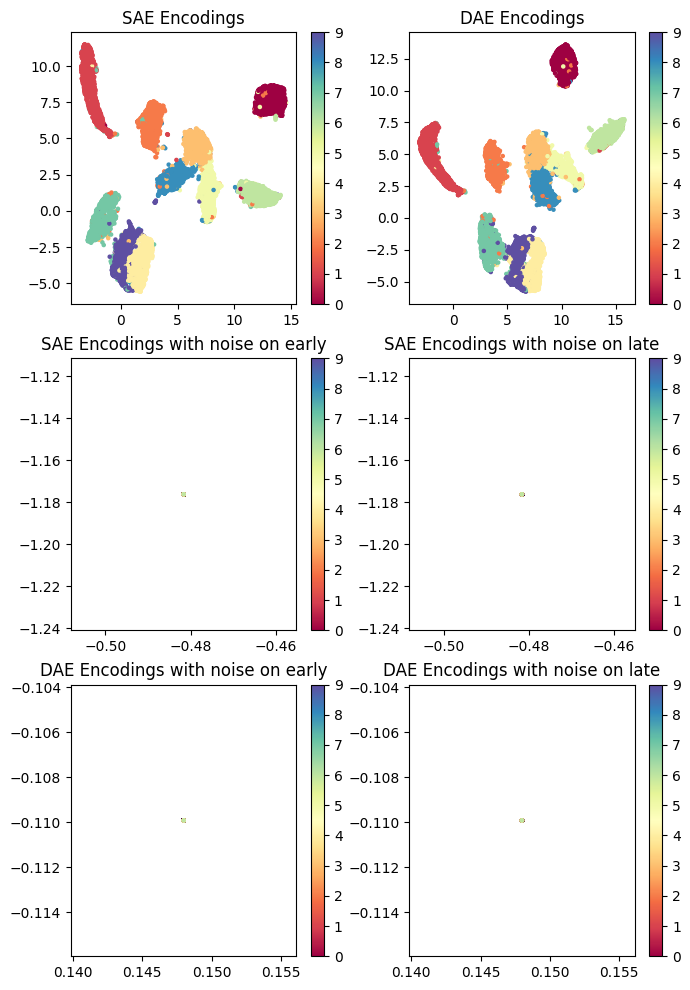

In [62]:
plt.figure(figsize=(8, 12))

plt.subplot(3, 2, 1)
scatter = plt.scatter(sae_umap[:, 0], sae_umap[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("SAE Encodings")

plt.subplot(3, 2, 2)
scatter = plt.scatter(dae_umap[:, 0], dae_umap[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("DAE Encodings")

plt.subplot(3, 2, 3)
scatter = plt.scatter(sae_encodings_noise_on_early[:, 0], sae_encodings_noise_on_early[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("SAE Encodings with noise on early")

plt.subplot(3, 2, 4)
scatter = plt.scatter(sae_encodings_noise_on_late[:, 0], sae_encodings_noise_on_late[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("SAE Encodings with noise on late")

plt.subplot(3, 2, 5)
scatter = plt.scatter(dae_encodings_noise_on_early[:, 0], dae_encodings_noise_on_early[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("DAE Encodings with noise on early")

plt.subplot(3, 2, 6)
scatter = plt.scatter(dae_encodings_noise_on_late[:, 0], dae_encodings_noise_on_late[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("DAE Encodings with noise on late")

plt.show()